# Setup

In [ ]:
!pip install segmentation-models-pytorch
!pip install torch torchvision

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=4bbe6b45b47e31d4889f5625895120be6bb91331c8c304064cbcb80cd671aed4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ffd8c8772f13c2bcd9fb0727f21102e03ce7ce5c497b26d2e28930080672fad3
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
import torch
import numpy as np
from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split # This line was added to import the missing function
import os
import re
import random
import matplotlib.pyplot as plt
from PIL import Image

print(torch.cuda.is_available())  # Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

True
Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Prepare Data

In [ ]:
# Paths to your datasets
pointclouds_dir = '/content/drive/MyDrive/Pointclouds1'
orthophotos_dir = '/content/drive/MyDrive/Orthophotos1'
# Pattern to match the filenames (including the part identifier)
pattern = r"(\d+\.\d+)_(\d+\.\d+)_part_(\d+)_(\d+)"
def extract_numbers(filename):
    """Extract the numbers based on the pattern r'(\d+\.\d+)_(\d+\.\d+)_part_(\d+)_(\d+)'."""
    match = re.search(pattern, filename)
    if match:
        return float(match.group(1)), float(match.group(2)), int(match.group(3)), int(match.group(4))
    return None
def load_data():
    image_paths, depth_paths = [], []
    pointcloud_files = sorted(os.listdir(pointclouds_dir))
    orthophoto_files = sorted(os.listdir(orthophotos_dir))
    for ortho_file in orthophoto_files:
        if ortho_file.endswith('.jpg'):
            ortho_match = extract_numbers(ortho_file)
            if ortho_match is None:
                continue
            for pc_file in pointcloud_files:
                pc_match = extract_numbers(pc_file)
                if pc_match is None:
                    continue
                if ortho_match == pc_match:
                    image_path = os.path.join(orthophotos_dir, ortho_file)
                    depth_path = os.path.join(pointclouds_dir, pc_file)
                    image_paths.append(image_path)
                    depth_paths.append(depth_path)
                    break
    return image_paths, depth_paths
# Load the paths to images and depths
image_paths, depth_paths = load_data()
resize_size = (518, 518)
# Unified Dataset Class for Images and Depth Maps
class ImageDepthDataset(Dataset):
    def __init__(self, image_paths, depth_paths):
        self.image_paths = image_paths
        self.depth_paths = depth_paths
         # Define transformations for both images and depth maps
        self.common_transform = transforms.Compose([
            transforms.Resize(resize_size),  # Resize to same size
            transforms.Pad(padding=(0, 0, 26, 26), fill=0, padding_mode='constant'), # Pad to make dimensions divisible by 32
            transforms.ToTensor(),          # Convert to tensor
        ])
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        '''# Load and process image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        # Load and process depth map
        depth = np.load(self.depth_paths[idx])
        depth = np.where(depth < 0, 0, depth)
        depth = torch.tensor(depth).unsqueeze(0).float()
        return image, depth'''
        # Load and transform the image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.common_transform(image)
        # Load and transform the depth map
        depth = np.load(self.depth_paths[idx])
        depth = np.where(depth < 0, 0, depth)  # Replace negative values with 0
        depth = torch.tensor(depth).unsqueeze(0)  # Add channel dimension
        depth = transforms.functional.resize(depth, image.shape[1:])  # Resize depth to match image
        return image, depth
# Debugging function to visualize images and depth maps
def debug_visualize_samples(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        image, depth = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Convert back to HWC format for plotting
        depth = depth.squeeze().numpy()  # Remove channel dimension
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Image - Index {idx}")
        plt.subplot(1, 2, 2)
        plt.imshow(depth, cmap='plasma')
        plt.title(f"Depth Map - Index {idx}")
        plt.show()
# Create dataset
dataset = ImageDepthDataset(image_paths, depth_paths)
# Split the dataset into train and test sets
#indices = list(range(len(dataset)))
#train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
# Create Subset Datasets for train and test
#train_dataset = Subset(dataset, train_indices)
#test_dataset = Subset(dataset, test_indices)
# Visualize some samples before creating DataLoaders
#debug_visualize_samples(train_dataset, num_samples=5)

In [ ]:
print(len(dataset))  # sollte 6842 ausgeben

8553


In [ ]:
# Dataloader for train and test sets
#train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=2)
#test_loader = DataLoader(test_dataset, batch_size=40, shuffle=False, num_workers=2)


**Speichern der Test- & Trainingsdaten (mit NumPy)**

In [ ]:
# Speichern der Indizes mit NumPy
np.save('train_indices.npy', train_indices)
np.save('test_indices.npy', test_indices)

# Pfad zum Speicherort in Google Drive
google_drive_path = '/content/drive/MyDrive/Model/train_indices.npy'  # Ersetzen Sie dies durch Ihren tatsächlichen Pfad

# Speichern der Indizes mit NumPy
np.save(google_drive_path, train_indices)

# Pfad zum Speicherort in Google Drive
google_drive_path = '/content/drive/MyDrive/Model/test_indices.npy'  # Ersetzen Sie dies durch Ihren tatsächlichen Pfad

# Speichern der Indizes mit NumPy
np.save(google_drive_path, test_indices)

NameError: name 'train_indices' is not defined

Laden der Indizies

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Pfad zur Datei im Google Drive
train_indices_path = '/content/drive/MyDrive/Model/train_indices.npy'
test_indices_path = '/content/drive/MyDrive/Model/test_indices.npy'

train_indices = np.load(train_indices_path)
test_indices = np.load(test_indices_path)

In [ ]:
print(len(train_indices))
print(len(test_indices))

6842
1711


Verwenden der Indizies

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# Seed setzen
random.seed(42)

train_loader = DataLoader(
    dataset,
    batch_size=40,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=2
)
test_loader = DataLoader(
    dataset,
    batch_size=40,
    sampler=SubsetRandomSampler(test_indices),
    num_workers=2
)

**Überprüfen**

In [ ]:
print(f"Anzahl der Trainingsbeispiele: {len(train_indices)}")
print(f"Anzahl der Testbeispiele: {len(test_indices)}")
print(f"Anzahl der Batches im Train Loader: {len(train_loader)}")
print(f"Anzahl der Batches im Test Loader: {len(test_loader)}")


Anzahl der Trainingsbeispiele: 6842
Anzahl der Testbeispiele: 1711
Anzahl der Batches im Train Loader: 172
Anzahl der Batches im Test Loader: 43


In [ ]:
# Ersten Batch aus dem Train Loader und Test Loader ansehen
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))

# Informationen zu den Batches anzeigen
print(f"Train Batch - Image Shape: {train_batch[0].shape}, Depth Shape: {train_batch[1].shape}")
print(f"Test Batch - Image Shape: {test_batch[0].shape}, Depth Shape: {test_batch[1].shape}")


Train Batch - Image Shape: torch.Size([40, 3, 544, 544]), Depth Shape: torch.Size([40, 1, 544, 544])
Test Batch - Image Shape: torch.Size([40, 3, 544, 544]), Depth Shape: torch.Size([40, 1, 544, 544])


# Model Training

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

# Initialize the U-Net model with a ResNet backbone
model = smp.Unet(
    encoder_name="resnet34",  # Use a pre-trained encoder
    encoder_weights="imagenet",
    in_channels=3,  # RGB input
    classes=1  # Single output channel for the z-coordinate
)

# Define the Mean Absolute Error (MAE) loss
loss_fn = nn.L1Loss()

# Example optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Verschiebe das Modell auf die GPU
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 427MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU if available
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, depths in train_loader:
        images = images.to(device)
        depths = depths.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_fn(outputs, depths)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    torch.cuda.empty_cache()  # Leere den Cache nach jeder Epoche, wenn nötig

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 4.2033
Epoch [2/5], Loss: 3.2548
Epoch [3/5], Loss: 2.5166
Epoch [4/5], Loss: 2.0064
Epoch [5/5], Loss: 1.7665


# Speichern Modell

In [ ]:
# Speicherfunktion für das Modell
save_path = '/content/drive/MyDrive/Model/model1_epoch_{epoch+1}.pth'  # Pfad, wo das Modell gespeichert wird

# Am Ende jeder Epoche speichern
torch.save(model.state_dict(), save_path)

print(f'Model saved after epoch {epoch+1} at {save_path}')


Model saved after epoch 5 at /content/drive/MyDrive/Model/model1_epoch_{epoch+1}.pth


# Modell Laden & Evaluate

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

In [ ]:
# Um das Modell wieder zu laden
model = smp.Unet(
    encoder_name="resnet34",  # Use the same encoder
    encoder_weights=None,  # Set to None when loading a saved model
    in_channels=3,  # RGB input
    classes=1  # Single output channel for the z-coordinate
)

# Lade die Modellparameter
model.load_state_dict(torch.load('/content/drive/MyDrive/model_epoch_{epoch+1}.pth'))  # Pfad anpassen
model.to(device)  # Auf GPU/CPU verschieben
model.eval()  # In den Evaluierungsmodus wechseln

def preprocess_images(images):
    processed_images = [image.unsqueeze(0) for image in images]
    return torch.cat(processed_images)


<ipython-input-10-9d2c27db09fb>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/model_epoch_{epoch+1}.pth'))  # Pf

Batch 0: Loss = 1.7347530126571655
Batch 1: Loss = 1.562399983406067
Batch 2: Loss = 2.2472314834594727
Batch 3: Loss = 1.8001794815063477
Batch 4: Loss = 1.6263545751571655
Batch 5: Loss = 1.941518783569336
Batch 6: Loss = 2.0960564613342285
Batch 7: Loss = 1.8213502168655396
Batch 8: Loss = 1.5121917724609375
Batch 9: Loss = 1.7514272928237915
Batch 10: Loss = 1.3907278776168823
Batch 11: Loss = 1.6531157493591309
Batch 12: Loss = 1.2019659280776978
Batch 13: Loss = 1.6050586700439453
Batch 14: Loss = 1.8437479734420776
Batch 15: Loss = 1.4360814094543457
Batch 16: Loss = 1.6275718212127686
Batch 17: Loss = 1.6729066371917725
Batch 18: Loss = 1.2123185396194458
Batch 19: Loss = 2.1890597343444824
Batch 20: Loss = 2.2566936016082764
Batch 21: Loss = 1.5200698375701904
Batch 22: Loss = 1.5609898567199707
Batch 23: Loss = 2.042677879333496
Batch 24: Loss = 1.8687851428985596
Batch 25: Loss = 2.0755696296691895
Batch 26: Loss = 1.3555824756622314
Batch 27: Loss = 2.776118755340576
Batch 

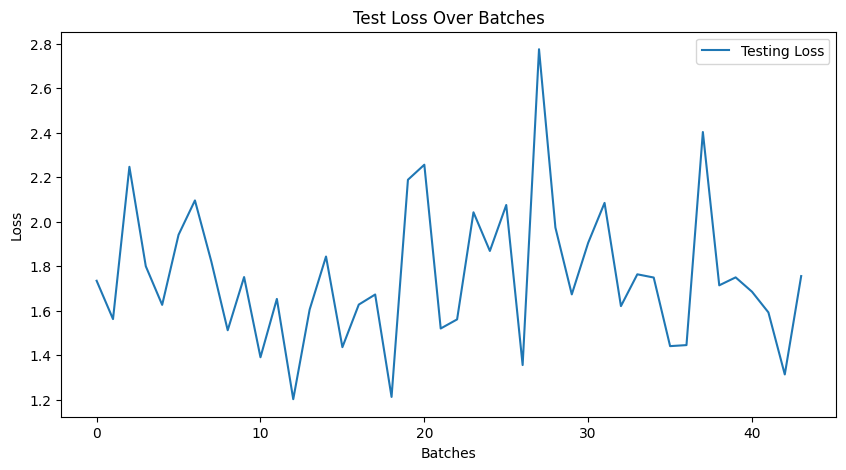

Number of predictions: 0


In [ ]:
import torch
import matplotlib.pyplot as plt
import gc
from torch.nn import HuberLoss

# Initialize lists to store test losses and predictions
test_losses = []
predictions = []

# Move the model to CPU for evaluation
model.to('cpu')
model.eval()

# Define Huber loss function
huber_loss_fn = HuberLoss(reduction='mean', delta=1.0)  # Adjust delta as necessary

# Define evaluation function
def evaluate_model(model, test_loader):
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (images, depths) in enumerate(test_loader):
            # Preprocess the images if needed
            processed_images = preprocess_images(images)
            procesed_images = processed_images.to('cpu')
            depths = depths.to('cpu')

            # Forward pass to predict depths
            outputs = model(processed_images)

            # Assuming your model directly outputs the predicted depth:
            predicted_depths = outputs  # Assign outputs directly

            # Add a channel dimension if necessary (if your model's output doesn't already have it)
            if len(predicted_depths.shape) == 3:  # Check if it's already 4D (B, C, H, W)
                predicted_depths = predicted_depths.unsqueeze(1)

            # Ensure that predicted_depths and depths have the same shape
            if predicted_depths.shape != depths.shape:
                print(f"Shape mismatch: predicted_depths {predicted_depths.shape}, depths {depths.shape}")
                continue  # Skip this batch if there's a shape mismatch

            # Compute the loss for this batch
            loss = huber_loss_fn(predicted_depths, depths)
            test_losses.append(loss.item())  # Store the loss for each batch
            print(f"Batch {batch_idx}: Loss = {loss.item()}")

            # Visualize the predicted depth, original input, and ground truth depth
            #print(f"Batch {batch_idx}:")
            #print("Predicted Depth Shape:", predicted_depths.shape)

            # Loop through each sample in the batch
            #for i in range(len(images)):
                # Get min and max values for the current instance (predicted vs ground truth)
             #   min_val = min(predicted_depths[i].min().item(), depths[i].min().item())
              #  max_val = max(predicted_depths[i].max().item(), depths[i].max().item())

                # Plot the predicted depth map for the current instance
               # plt.imshow(predicted_depths[i].squeeze().cpu(), cmap='inferno', vmin=min_val, vmax=max_val)
               # plt.colorbar()
               # plt.title(f'Predicted Depth Map')
               # plt.show()

                # Plot the ground truth depth map for the current instance
              # plt.imshow(depths[i].squeeze().cpu(), cmap='inferno', vmin=min_val, vmax=max_val)
              # plt.colorbar()
              # plt.title(f'Ground Truth Depth Map')
              # plt.show()

                # Plot the processed image for the current instance
              # plt.imshow(processed_images[i].permute(1, 2, 0).cpu())
              # plt.title(f'Processed Image')
             #  plt.show()

                # Append the predicted depths to the predictions list (convert to CPU)
              #  predictions.append(predicted_depths[i].cpu().numpy())

            # Compute the loss
            loss = huber_loss_fn(predicted_depths, depths)
            total_loss += loss.item()

    # Calculate the average loss for the test set and store it
    average_loss = total_loss / len(test_loader)
    test_losses.append(average_loss)
    print(f"Test Loss: {average_loss}")

# Evaluate the model
evaluate_model(model, test_loader)

# Plot the test loss over batches
plt.figure(figsize=(10, 5))
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Test Loss Over Batches')
plt.legend()
plt.show()

# Clear up memory after the run
gc.collect()
torch.cuda.empty_cache()

# Check predictions
print(f"Number of predictions: {len(predictions)}")

# Model benutzen

In [ ]:
!pip install segmentation-models-pytorch
!pip install torch torchvision

import torch
import numpy as np
import segmentation_models_pytorch as smp
from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split # This line was added to import the missing function
import os
import re
import random
import matplotlib.pyplot as plt
from PIL import Image
from transformers import DepthAnythingConfig, DepthAnythingForDepthEstimation, AutoImageProcessor, AutoModelForDepthEstimation


print(torch.cuda.is_available())  # Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fc44af0a433284ba55230fe20c5828009fb2489f588579c0ee5604f9c019aa96
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=acecadaa62650f8973467e60b87c3070118c74bc2a3c034cfaf43dad689e0367
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Um das Modell wieder zu laden
model = smp.Unet(
    encoder_name="resnet34",  # Use the same encoder
    encoder_weights=None,  # Set to None when loading a saved model
    in_channels=3,  # RGB input
    classes=1  # Single output channel for the z-coordinate
)

# Lade die Modellparameter
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/model1_epoch_{5}.pth'))  # Pfad anpassen
model.to('cpu')  # Auf GPU/CPU verschieben
model.eval()  # In den Evaluierungsmodus wechseln

print("Model successfully loaded and ready for inference.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model successfully loaded and ready for inference.


<ipython-input-10-08b227f842e9>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Model/model1_epoch_{5}.pth'))  # P

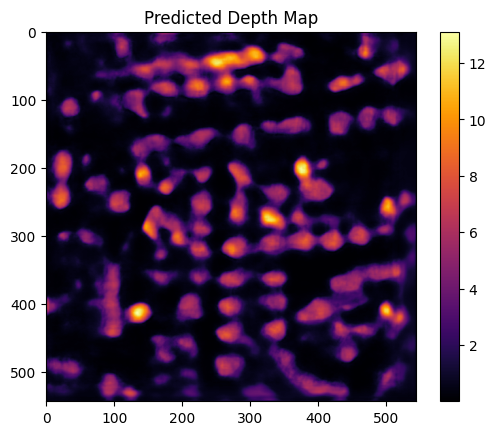

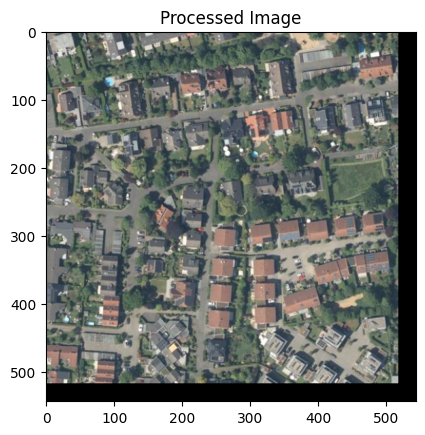

Depth Map saved to /content/drive/MyDrive/Depth_Maps_Basic_Model/predicted_depth_map_344000.0_5645000.0__1_0.png


In [ ]:
# Bildpfad
image_path = '/content/drive/MyDrive/Resized_Photos_fertig28/Häuser/Wohnhäuser/resized_344000.0_5645000.0__1_0.jpg'

# Bild einlesen und vorbereiten
def load_and_preprocess_image(image_path):
    # Bild öffnen
    image = Image.open(image_path).convert("RGB")

    # Transformationen definieren: passend für das trainierte Modell
    transform = transforms.Compose([
        transforms.Resize((518, 518)),  # Größe anpassen, falls notwendig
        transforms.Pad(padding=(0, 0, 26, 26), fill=0, padding_mode='constant'),
        transforms.ToTensor(),          # In Tensor umwandeln
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisieren, wenn das Modell dies erwartet
    ])

    # Transformation anwenden
    image = transform(image)
    # Batch-Dimension hinzufügen
    image = image.unsqueeze(0)
    return image

# Bild laden und vorverarbeiten
input_image = load_and_preprocess_image(image_path).to('cpu')

# Tiefenkarte vorhersagen
with torch.no_grad():  # keine Gradienten berechnen, da wir evaluieren
    predicted_depth = model(input_image)
    # Access the predicted depth from the output object
    #predicted_depth = predicted_depth.predicted_depth

# Vorhersage auf CPU verschieben und Dimensionen anpassen
predicted_depth = predicted_depth.squeeze().cpu()

#Plot the predicted depth map
plt.imshow(predicted_depth.squeeze().cpu(), cmap='inferno')
plt.colorbar()
plt.title(f'Predicted Depth Map')
plt.show()

# Falls processed_images verwendet wird und das Bild gespeichert ist
processed_images = [input_image]  # Beispielhafte Speicherung des Bildes

if len(processed_images) > 0:
    plt.imshow(processed_images[0].squeeze().permute(1, 2, 0).cpu())
    plt.title("Processed Image")
    plt.show()

# Speicherpfad für die Depth Map in Google Drive
output_path = '/content/drive/MyDrive/Depth_Maps_Basic_Model/predicted_depth_map_344000.0_5645000.0__1_0.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Verzeichnis erstellen, falls nicht vorhanden

# Depth Map speichern
plt.imsave(output_path, predicted_depth, cmap='inferno')
print(f"Depth Map saved to {output_path}")

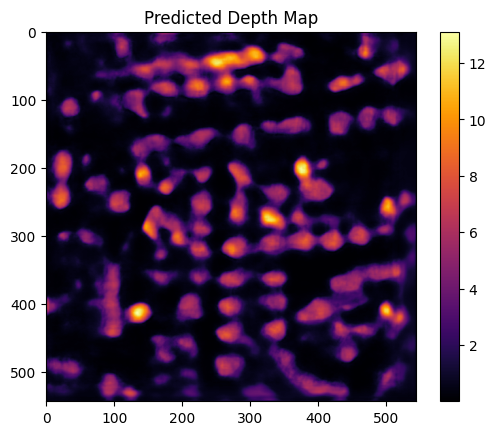

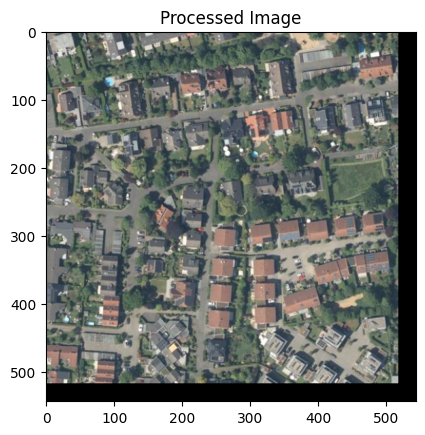

Depth Map saved to /content/drive/MyDrive/Depth_Maps_Basic_Model/predicted_depth_map_344000.0_5645000.0__1_0.png


In [ ]:
# Move the model to CPU for evaluation
model.to('cpu')
model.eval()

# Bildpfad
image_path = '/content/drive/MyDrive/Resized_Photos_fertig28/Häuser/Wohnhäuser/resized_344000.0_5645000.0__1_0.jpg'

# Bild einlesen und vorbereiten
def load_and_preprocess_image(image_path):
    # Bild öffnen
    image = Image.open(image_path).convert("RGB")

    # Transformationen definieren: passend für das trainierte Modell
    transform = transforms.Compose([
        transforms.Resize((518, 518)),  # Größe anpassen, falls notwendig
        transforms.Pad(padding=(0, 0, 26, 26), fill=0, padding_mode='constant'),
        transforms.ToTensor(),          # In Tensor umwandeln
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisieren, wenn das Modell dies erwartet
    ])

    # Transformation anwenden
    image = transform(image)
    # Batch-Dimension hinzufügen
    image = image.unsqueeze(0)
    return image

# Bild laden und vorverarbeiten
input_image = load_and_preprocess_image(image_path).to('cpu')

# Tiefenkarte vorhersagen
with torch.no_grad():  # keine Gradienten berechnen, da wir evaluieren
    predicted_depth = model(input_image)

# Vorhersage auf CPU verschieben und Dimensionen anpassen
predicted_depth = predicted_depth.squeeze().cpu()


#Plot the predicted depth map
plt.imshow(predicted_depth.squeeze().cpu(), cmap='inferno')
plt.colorbar()
plt.title(f'Predicted Depth Map')
plt.show()

# Falls processed_images verwendet wird und das Bild gespeichert ist
processed_images = [input_image]  # Beispielhafte Speicherung des Bildes

if len(processed_images) > 0:
    plt.imshow(processed_images[0].squeeze().permute(1, 2, 0).cpu())
    plt.title("Processed Image")
    plt.show()

# Speicherpfad für die Depth Map in Google Drive
output_path = '/content/drive/MyDrive/Depth_Maps_Basic_Model/predicted_depth_map_344000.0_5645000.0__1_0.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Verzeichnis erstellen, falls nicht vorhanden

# Depth Map speichern
plt.imsave(output_path, predicted_depth, cmap='inferno')
print(f"Depth Map saved to {output_path}")

# Depth & Basic Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

modelDA = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Base-hf")

modelDA.load_state_dict(torch.load("/content/drive/MyDrive/Models/depth_anything_16k_mix_batch_40_lr_0.0005_epoch_9.pth",weights_only=False,map_location=torch.device('cpu')))  # Use 'cuda' if using GPU, otherwise 'cpu'
modelDA.to('cpu')  # If using GPU
modelDA.eval()  # Set the model to evaluation mode

print("DepthAnything Model successfully loaded and ready for inference.")

# Um das Modell wieder zu laden
modelB = smp.Unet(
    encoder_name="resnet34",  # Use the same encoder
    encoder_weights=None,  # Set to None when loading a saved model
    in_channels=3,  # RGB input
    classes=1  # Single output channel for the z-coordinate
)

# Lade die Modellparameter
modelB.load_state_dict(torch.load('/content/drive/MyDrive/Model/model1_epoch_{5}.pth'))  # Pfad anpassen
modelB.to('cpu')  # Auf GPU/CPU verschieben
modelB.eval()  # In den Evaluierungsmodus wechseln

print("Basic Model successfully loaded and ready for inference.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DepthAnything Model successfully loaded and ready for inference.


<ipython-input-10-d7b8df1df6ca>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelB.load_state_dict(torch.load('/content/drive/MyDrive/Model/model1_epoch_{5}.pth'))  # 

Basic Model successfully loaded and ready for inference.


In [ ]:
# Bildpfad
image_path = '/content/drive/MyDrive/Resized_Photos_fertig28/Häuser/Wohnhäuser/resized_344000.0_5645000.0__1_0.jpg'

# Bild einlesen und vorbereiten
def load_and_preprocess_image(image_path):
    # Bild öffnen
    image = Image.open(image_path).convert("RGB")

    # Transformationen definieren: passend für das trainierte Modell
    transform = transforms.Compose([
        transforms.Resize((518, 518)),  # Größe anpassen, falls notwendig
        transforms.Pad(padding=(0, 0, 26, 26), fill=0, padding_mode='constant'),
        transforms.ToTensor(),          # In Tensor umwandeln
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisieren, wenn das Modell dies erwartet
    ])

    # Transformation anwenden
    image = transform(image)
    # Batch-Dimension hinzufügen
    image = image.unsqueeze(0)
    return image

# Bild laden und vorverarbeiten
input_image = load_and_preprocess_image(image_path).to('cpu')



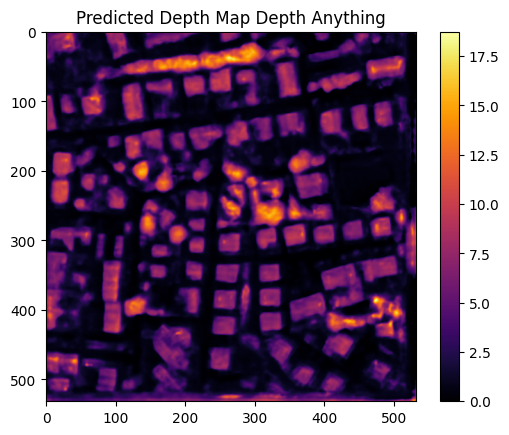

Gemeinsame Skala - Minimum: 0.0, Maximum: 18.743675231933594


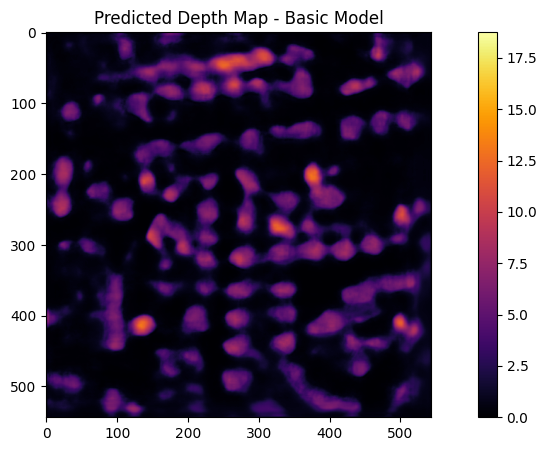

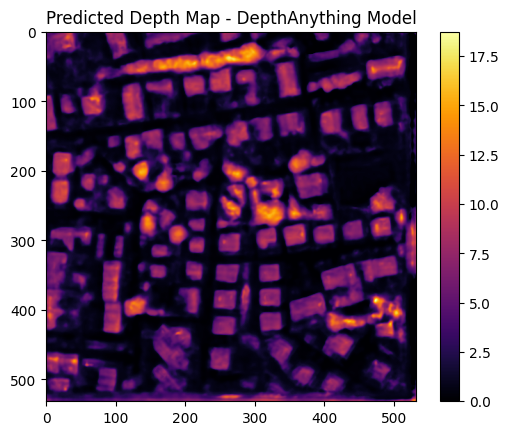

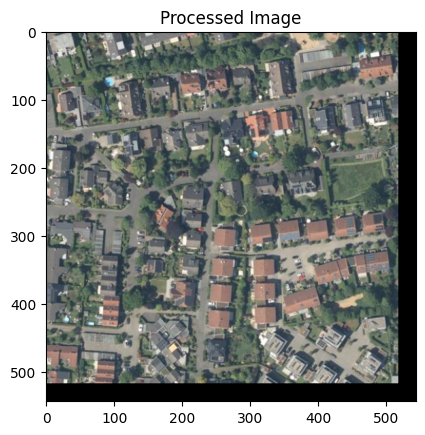

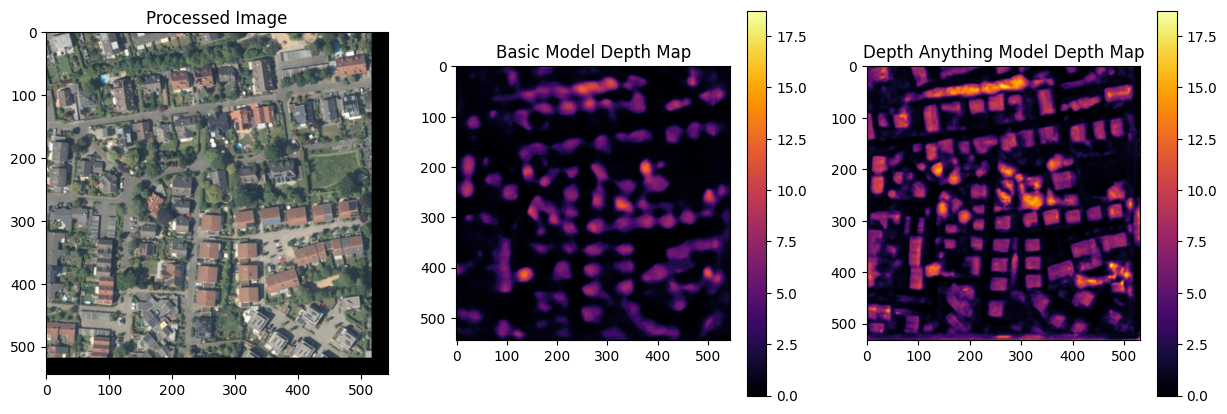

Combined Depth Maps saved to /content/drive/MyDrive/Predicted_Depth_Maps/predicted_depth_map_344000.0_5645000.0__1_0.png


In [ ]:
# Tiefenkarte vorhersagen Depth Anything
with torch.no_grad():  # keine Gradienten berechnen, da wir evaluieren
    predicted_depthDA = modelDA(input_image)
    # Access the predicted depth from the output object
    predicted_depthDA = predicted_depthDA.predicted_depth

# Vorhersage auf CPU verschieben und Dimensionen anpassen
predicted_depthDA = predicted_depthDA.squeeze().cpu()

#Plot the predicted depth map
plt.imshow(predicted_depthDA.squeeze().cpu(), cmap='inferno')
plt.colorbar()
plt.title(f'Predicted Depth Map Depth Anything')
plt.show()

# Tiefenkarte vorhersagen Basic
with torch.no_grad():  # keine Gradienten berechnen, da wir evaluieren
    predicted_depthB = modelB(input_image)
    # Access the predicted depth from the output object
#predicted_depthB = predicted_depthB.predicted_depth

# Vorhersage auf CPU verschieben und Dimensionen anpassen
predicted_depthB = predicted_depthB.squeeze().cpu()

# Min- und Max-Werte berechnen
vmin = min(predicted_depthB.min(), predicted_depthDA.min()) # Changed depth_basic to predicted_depthB and depth_anything to predicted_depthDA
vmax = max(predicted_depthB.max(), predicted_depthDA.max()) # Changed depth_basic to predicted_depthB and depth_anything to predicted_depthDA
print(f"Gemeinsame Skala - Minimum: {vmin}, Maximum: {vmax}")

# Tiefenkarten mit derselben Skala plotten
plt.figure(figsize=(12, 5))

#Plot the predicted depth map Basic Model
plt.imshow(predicted_depthB.squeeze().cpu(), cmap='inferno', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Predicted Depth Map - Basic Model')
plt.show()

#Plot the predicted depth map DepthAnything Model
plt.imshow(predicted_depthDA.squeeze().cpu(), cmap='inferno', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Predicted Depth Map - DepthAnything Model')
plt.show()

# Falls processed_images verwendet wird und das Bild gespeichert ist
processed_images = [input_image]  # Beispielhafte Speicherung des Bildes

if len(processed_images) > 0:
    plt.imshow(processed_images[0].squeeze().permute(1, 2, 0).cpu())
    plt.title("Processed Image")
    plt.show()

# Speicherpfad für die Depth Map in Google Drive
output_path = '/content/drive/MyDrive/Predicted_Depth_Maps/predicted_depth_map_344000.0_5645000.0__1_0.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Verzeichnis erstellen, falls nicht vorhanden

# Depth Map speichern
# Erstelle eine neue Figur mit drei Unterplots
plt.figure(figsize=(15, 5))

# Plot 1: Processed Image
plt.subplot(1, 3, 1)
plt.imshow(processed_images[0].squeeze().permute(1, 2, 0).cpu())
plt.title("Processed Image")

# Plot 2: Basic Depth Map
plt.subplot(1, 3, 2)
plt.imshow(predicted_depthB, cmap='inferno', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Basic Model Depth Map")

# Plot 3: Depth Anything Model Depth Map
plt.subplot(1, 3, 3)
plt.imshow(predicted_depthDA, cmap='inferno', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Depth Anything Model Depth Map")

# Speicher die kombinierte Abbildung als eine Datei
plt.savefig(output_path, bbox_inches='tight')
plt.show()
print(f"Combined Depth Maps saved to {output_path}")